# Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import io
from torchvision.transforms import v2
from torchvision import models

from PIL import Image

import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
from tqdm.auto import tqdm

import re

c:\Users\NITRO5\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create Dataset and DataLoader

In [2]:
files = Path("../data/images")
categories = sorted({"".join(re.findall(r"(.+)_\d+$", file.stem)) for file in files.iterdir()})

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transforms = None):
        self.root_dir = Path(root_dir)
        self.transforms = transforms
        self.files = [file for file in self.root_dir.glob("*.jpg")]
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        img = v2.PILToTensor()(img.convert("RGB"))
        img_label = "".join(re.findall(r"(.+)_\d+$", self.files[idx].stem))
        img_label_tensor = categories.index(img_label)
        
        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, img_label_tensor

In [4]:
dataset = CustomDataset(
    root_dir = "../data/images",
    transforms = v2.Compose([
        v2.RandomResizedCrop(size = (224, 224), antialias = True),
        v2.RandomHorizontalFlip(p = 0.5),
        v2.ToDtype(torch.float, scale = True)
    ])
)
generator = torch.Generator().manual_seed(41)
train_set_len = (0.8 * len(dataset)) / len(dataset)
valid_set_len = 1 - train_set_len
train_set, valid_set = random_split(dataset, [train_set_len, valid_set_len], generator = generator)

In [5]:
# Test for num_workers > 0 with persistent_workers by creating modules

train_dataloader = DataLoader(
    dataset = train_set,
    batch_size = 8,
    shuffle = True,
    num_workers = 0,
    pin_memory = True,
    # persistent_workers = True
)

valid_dataloader = DataLoader(
    dataset = valid_set,
    batch_size = 8,
    shuffle = True,
    num_workers = 0,
    pin_memory = True,
    # persistent_workers = True
)

# Transfer Learning with ConvNeXt Tiny Model

In [6]:
class DiscriminativeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = models.convnext_tiny(weights = models.ConvNeXt_Tiny_Weights.DEFAULT)
        
        for param in self.model.parameters():
            if isinstance(param, nn.Conv2d):
                param.requires_grad = False 
                
        num_features = self.model.classifier[2].in_features
        
        self.model.classifier[2] = nn.Sequential(
            nn.Linear(in_features = num_features, out_features = 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 256, out_features = 37),
            nn.LogSoftmax(dim = 1)
        )
                
    def forward(self, input):
        return self.model(input)
    
    def training_step(self, dataloader, criterion, optimizer, device):
        self.train() 
        
        train_loss, train_acc = 0.0, 0.0
        
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            y_pred = self(X)
            
            loss = criterion(y_pred, y)
            train_loss += loss.item()
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            y_pred_class = torch.argmax(y_pred, dim = 1)
            train_acc += (y_pred_class == torch.flatten(y)).sum() / len(y_pred)
            
        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)
        
        return train_loss, train_acc
    
    def validation_step(self, dataloader, criterion, device):
        self.eval()
        
        val_loss, val_acc = 0.0, 0.0
        
        with torch.inference_mode():
            for (X, y) in dataloader:
                X, y = X.to(device), y.to(device)
                
                val_pred = self(X)
                
                loss = criterion(val_pred, torch.flatten(y))
                val_loss += loss.item()
                
                val_pred_class = torch.argmax(val_pred, dim = 1)
                val_acc += (val_pred_class == torch.flatten(y)).sum().item() / len(val_pred)
                
        val_loss = val_loss / len(dataloader)
        val_acc = val_acc / len(dataloader)
        
        return val_loss, val_acc

In [7]:
d_classifier = DiscriminativeClassifier()

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(d_classifier.model.classifier[2].parameters(), lr = 0.005)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"


In [8]:
def train(
    model,
    train_dataloader,
    valid_dataloader,
    criterion,
    epochs,
    device,
):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = model.training_step(
            dataloader = train_dataloader,
            criterion = criterion,
            optimizer = optimizer,
            device = device
        )
        
        val_loss, val_acc = model.validation_step(
            dataloader = valid_dataloader,
            criterion = criterion,
            device = device
        )
        
        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"valid_loss: {val_loss:.4f} | "
            f"valid_acc: {val_acc:.4f}"
        )
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(val_loss)
        results["test_acc"].append(val_acc)
        
    return results

In [28]:
history = train(
    model = d_classifier.to(device),
    train_dataloader = train_dataloader,
    valid_dataloader = valid_dataloader,
    criterion = criterion,
    epochs = 5,
    device = device
)

 20%|██        | 1/5 [05:34<22:17, 334.48s/it]

Epoch: 1 | train_loss: 3.3948 | train_acc: 0.2292 | valid_loss: 3.0628 | valid_acc: 0.5974


 40%|████      | 2/5 [11:09<16:44, 334.69s/it]

Epoch: 2 | train_loss: 2.6277 | train_acc: 0.5431 | valid_loss: 2.0392 | valid_acc: 0.7732


 60%|██████    | 3/5 [16:42<11:07, 333.88s/it]

Epoch: 3 | train_loss: 1.7460 | train_acc: 0.6605 | valid_loss: 1.3041 | valid_acc: 0.7816


 80%|████████  | 4/5 [20:46<04:58, 298.36s/it]

Epoch: 4 | train_loss: 1.2650 | train_acc: 0.7176 | valid_loss: 0.9562 | valid_acc: 0.8203


100%|██████████| 5/5 [24:33<00:00, 294.71s/it]

Epoch: 5 | train_loss: 0.9949 | train_acc: 0.7610 | valid_loss: 0.7879 | valid_acc: 0.8415


{'train_loss': [3.3947923257544232,
  2.627669385961584,
  1.7459506132312723,
  1.2650108476345603,
  0.9948702872856646],
 'train_acc': [tensor(0.2292, device='cuda:0'),
  tensor(0.5431, device='cuda:0'),
  tensor(0.6605, device='cuda:0'),
  tensor(0.7176, device='cuda:0'),
  tensor(0.7610, device='cuda:0')],
 'test_loss': [3.0628356972256223,
  2.039195489883423,
  1.3041039740717089,
  0.9562358835258999,
  0.7878805512512053],
 'test_acc': [0.5974324324324325,
  0.7732432432432433,
  0.7816216216216216,
  0.8202702702702702,
  0.8414864864864865]}

In [30]:
torch.save(d_classifier.state_dict(), "../models/convnext.pth")

# Inference Example

In [84]:
img = io.read_image("../data/images/Abyssinian_1.jpg").float().to("cuda")
img = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale = True)
])(img)
img = img.unsqueeze(0)
idx = torch.argmax(d_classifier(img))
print(categories[idx])

Abyssinian


# Confusion Matrix

In [11]:
d_classifier = DiscriminativeClassifier()

d_classifier.load_state_dict(torch.load("../models/convnext.pth"))

d_classifier.to(device)

cm_array = np.zeros((37, 37))

for (X, y) in valid_dataloader:
    X, y = X.to(device), y.to(device)
    y_pred = d_classifier(X)
    y_pred_class = torch.argmax(y_pred, dim = 1)
    
    for i in range(len(y)):
        cm_array[y[i]][y_pred_class[i]] += 1

<Axes: >

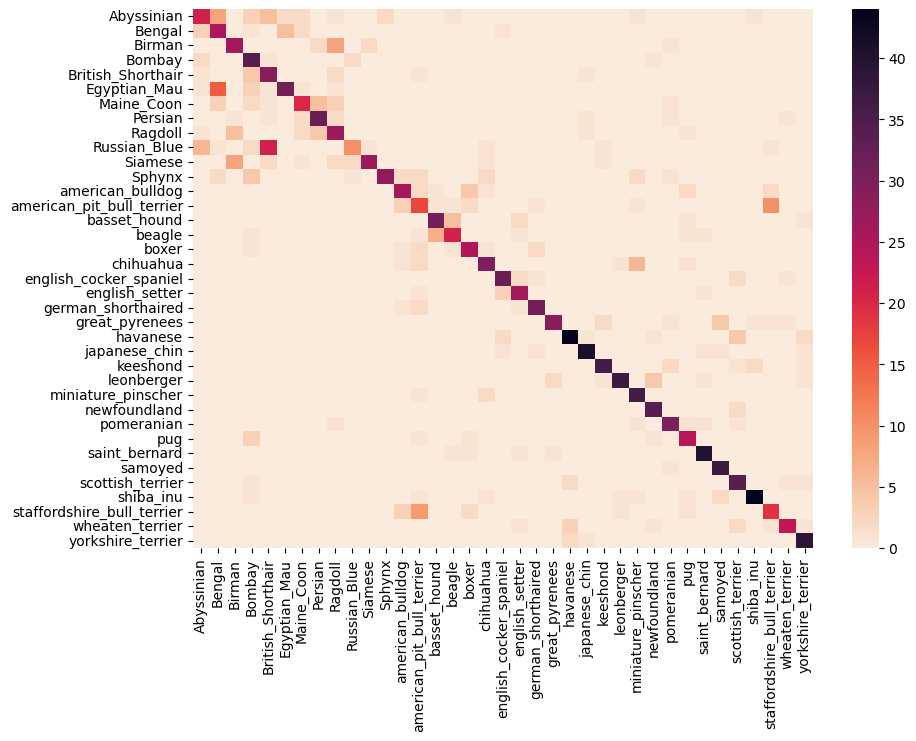

In [12]:
cm_df = pd.DataFrame(
    data = cm_array,
    index = [x for x in categories],
    columns = [x for x in categories]
)

plt.figure(figsize = (10, 7))

sn.heatmap(cm_df, cmap = sn.cm.rocket_r)